Set OBSGEO-B to    -6.003921 from OBSGEO-[XYZ].
Set OBSGEO-H to 1334398781.814 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2023-09-10T05:47:44.353' from MJD-AVG.
Set DATE-END to '2023-09-10T08:04:22.856' from MJD-END'. [astropy.wcs.wcs]
[INFO] 632 x 71 x 75 Cube (/Users/mary/Fits image of JWST/ngc6302_ch4-medium_s3d.fits)
[INFO] .data(632 x 71 x 75) (MJy / sr), no noise
[INFO] center:(-37:06:12.7000602,-06:46:15.65735004) size:(24.850",26.250") step:(0.350",0.350") rot:-0.0 deg frame:ICRS
[INFO] wavelength: min:20.69 max:24.48 step:0.01 um
Set DATE-AVG to '2023-09-10T05:47:44.353' from MJD-AVG.
Set DATE-END to '2023-09-10T08:04:22.856' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to    -6.003921 from OBSGEO-[XYZ].
Set OBSGEO-H to 1334398781.814 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Wavelength range in data cube: 20.693000534083694 - 24.47900056699291 μm
Filtered Wavelengths: [22.00100055 22.00700055 22.01300055 22.01900055 22.02500055 22.03100055
 22.03700055 22.04300055 22.04900055 22.05500055 22.06100055 22.06700055
 22.07300055 22.07900055 22.08500055 22.09100055 22.09700055 22.10300055
 22.10900055 22.11500055 22.12100055 22.12700055 22.13300055 22.13900055
 22.14500055 22.15100055 22.15700055 22.16300055 22.16900055 22.17500055
 22.18100055 22.18700055 22.19300055 22.19900055 22.20500055 22.21100055
 22.21700055 22.22300055 22.22900055 22.23500055 22.24100055 22.24700055
 22.25300055 22.25900055 22.26500055 22.27100055 22.27700055 22.28300055
 22.28900055 22.29500055 22.30100055 22.30700055 22.31300055 22.31900055
 22.32500055 22.33100055 22.33700055 22.34300055 22.34900055 22.35500055
 22.36100055 22.36700055 22.37300055 22.37900055 22.38500055 22.39100055
 22.39700055 22.40300055 22.40900055 22.41500055 22.42100055 22.42700055
 22.43300055 22.43900055 22.4

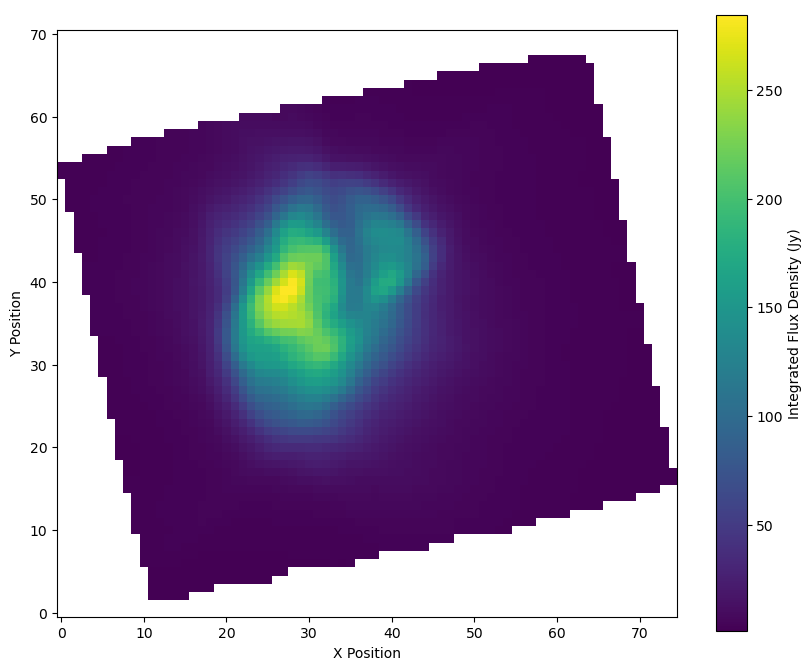

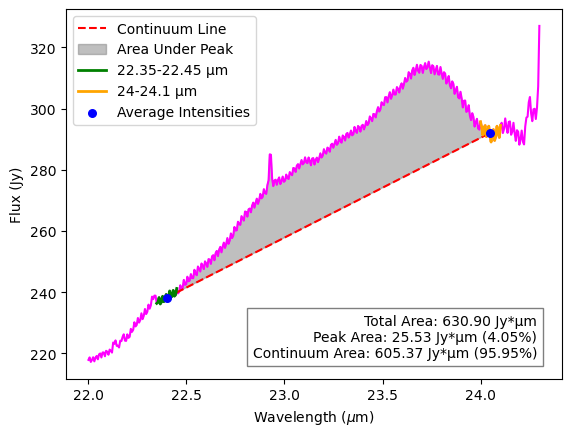

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.wcs import WCS
from mpdaf.obj import Cube
from astropy.io import fits

obj1 = Cube('/Users/mary/Fits image of JWST/ngc6302_ch4-medium_s3d.fits')
obj1.info()

pixel_size = obj1.wcs.get_step(unit=u.arcsec)[0] 
solid_angle = (pixel_size * u.arcsec).to(u.rad)**2

def process_slices_in_range(cube, solid_angle, wavelength_min, wavelength_max):
    wavelength = cube.wave.coord()
    print(f"Wavelength range in data cube: {wavelength.min()} - {wavelength.max()} μm")
    
    mask = (wavelength >= wavelength_min) & (wavelength <= wavelength_max)
    filtered_wavelengths = wavelength[mask]
    print(f"Filtered Wavelengths: {filtered_wavelengths}")
    
    integrated_flux_density_map = np.zeros((cube.shape[1], cube.shape[2]))
    for i in range(cube.shape[0]):
        if mask[i]:
            integrated_flux_density_map += cube.data[i, :, :] * solid_angle.value * 1e6

    if np.all(integrated_flux_density_map == 0):
        return

    
    cube_header = fits.getheader('/Users/mary/Fits image of JWST/ngc6302_ch4-medium_s3d.fits', ext=1)  
    cube_wcs = WCS(cube_header).celestial 
    fits.writeto('/Users/mary/Fits image of JWST/test.fits', integrated_flux_density_map, header=cube_header, overwrite=True)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(integrated_flux_density_map, cmap='viridis', origin='lower')
    plt.colorbar(label='Integrated Flux Density (Jy)')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title(f' ')
    plt.savefig('integrated_flux_density_map_FEATURE 23.71.png', dpi=300, bbox_inches='tight')
    plt.show()

    filtered_flux_density = np.zeros(len(filtered_wavelengths))
    for i, wl in enumerate(filtered_wavelengths):
        filtered_flux_density[i] = np.sum(cube.data[mask][i, :, :]) * solid_angle.value * 1e6

   
    mask_start = (filtered_wavelengths >= 22.35) & (filtered_wavelengths <= 22.45)
    continuum_start = np.mean(filtered_flux_density[mask_start])

    mask_end = (filtered_wavelengths >= 24) & (filtered_wavelengths <= 24.1)
    continuum_end = np.mean(filtered_flux_density[mask_end])

    wavelengths = [22.4, 24.05]
    average_intensities = [continuum_start, continuum_end]

    # I do interpolate for the continuum line 
    continuum_line = np.interp(filtered_wavelengths, wavelengths, average_intensities)

    plt.figure()
    plt.plot(filtered_wavelengths, filtered_flux_density, color='magenta')
    plt.plot([22.4, 24.05], [continuum_start, continuum_end], label='Continuum Line', color='red', linestyle='--')


    wavelength_condition = (filtered_wavelengths >= 22.4) & (filtered_wavelengths <= 24.05)

  
    plt.fill_between(filtered_wavelengths, filtered_flux_density, continuum_line, 
                     where=(filtered_flux_density > continuum_line) & wavelength_condition, 
                     color='gray', alpha=0.5, label='Area Under Peak')
    #calculate the area
    total_area = np.trapz(filtered_flux_density, filtered_wavelengths)
    continuum_area = np.trapz(continuum_line, filtered_wavelengths)
    peak_area = total_area - continuum_area

    peak_area_percentage = (peak_area / total_area) * 100
    continuum_area_percentage = (continuum_area / total_area) * 100

    annotation_text = (f'Total Area: {total_area:.2f} Jy*μm\n'
                       f'Peak Area: {peak_area:.2f} Jy*μm ({peak_area_percentage:.2f}%)\n'
                       f'Continuum Area: {continuum_area:.2f} Jy*μm ({continuum_area_percentage:.2f}%)')
    plt.annotate(annotation_text, xy=(0.95, 0.05), xycoords='axes fraction', fontsize=10, color='black',
                 ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.5))

    idx_22_2 = np.argmin(np.abs(filtered_wavelengths - 22.35))
    idx_22_4 = np.argmin(np.abs(filtered_wavelengths - 22.45))
    plt.plot(filtered_wavelengths[idx_22_2:idx_22_4 + 1], filtered_flux_density[idx_22_2:idx_22_4 + 1], color='green', linestyle='-', linewidth=2, label='22.35-22.45 μm')

    idx_23_9 = np.argmin(np.abs(filtered_wavelengths - 24))
    idx_24_1 = np.argmin(np.abs(filtered_wavelengths - 24.1))
    plt.plot(filtered_wavelengths[idx_23_9:idx_24_1 + 1], filtered_flux_density[idx_23_9:idx_24_1 + 1], color='orange', linestyle='-', linewidth=2, label='24-24.1 μm')

   
    plt.scatter(wavelengths, average_intensities, color='blue', s=30, zorder=5, label='Average Intensities')

    plt.legend()
    plt.xlabel('Wavelength ($\mu$m)')
    plt.ylabel('Flux (Jy)')
    plt.title('')
    plt.savefig('SED OF FEATURE 23.71.png', dpi=300, bbox_inches='tight')
    plt.show()

process_slices_in_range(obj1, solid_angle, 22, 24.3)


